CARGA DE DATOS Y ANALISS EXPLORATORIO

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

#Archivos propios
import src.models as models
import src.preprocessing as pre
import src.metrics as metrics
import src.balancing as bal

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


In [2]:
# Cargo los datos
dev_df = pd.read_csv("./I302_ML_TP02_Ejercicio 2/Ejercicio 2/data/raw/WAR_class_dev.csv")
test_df = pd.read_csv("./I302_ML_TP02_Ejercicio 2/Ejercicio 2/data/raw/WAR_class_test.csv")


In [3]:
# Veo como esta compuesto
print(dev_df.info())
#print(test_df.info())

# Veo si hay NaNs
print('Nans dev:\n', dev_df.isna().sum())

# Analizo si hay filas duplicadas
num_duplicates = dev_df.duplicated().sum()
print(f"Número de filas duplicadas en dev_df: {num_duplicates}")

if num_duplicates > 0:
    print("Filas duplicadas:")
    display(dev_df[dev_df.duplicated(keep=False)])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6782 entries, 0 to 6781
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   poss          6782 non-null   float64
 1   mp            6782 non-null   float64
 2   raptor_total  6782 non-null   float64
 3   pace_impact   6782 non-null   float64
 4   war_class     6782 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 265.1 KB
None
Nans dev:
 poss            0
mp              0
raptor_total    0
pace_impact     0
war_class       0
dtype: int64
Número de filas duplicadas en dev_df: 0


c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-p

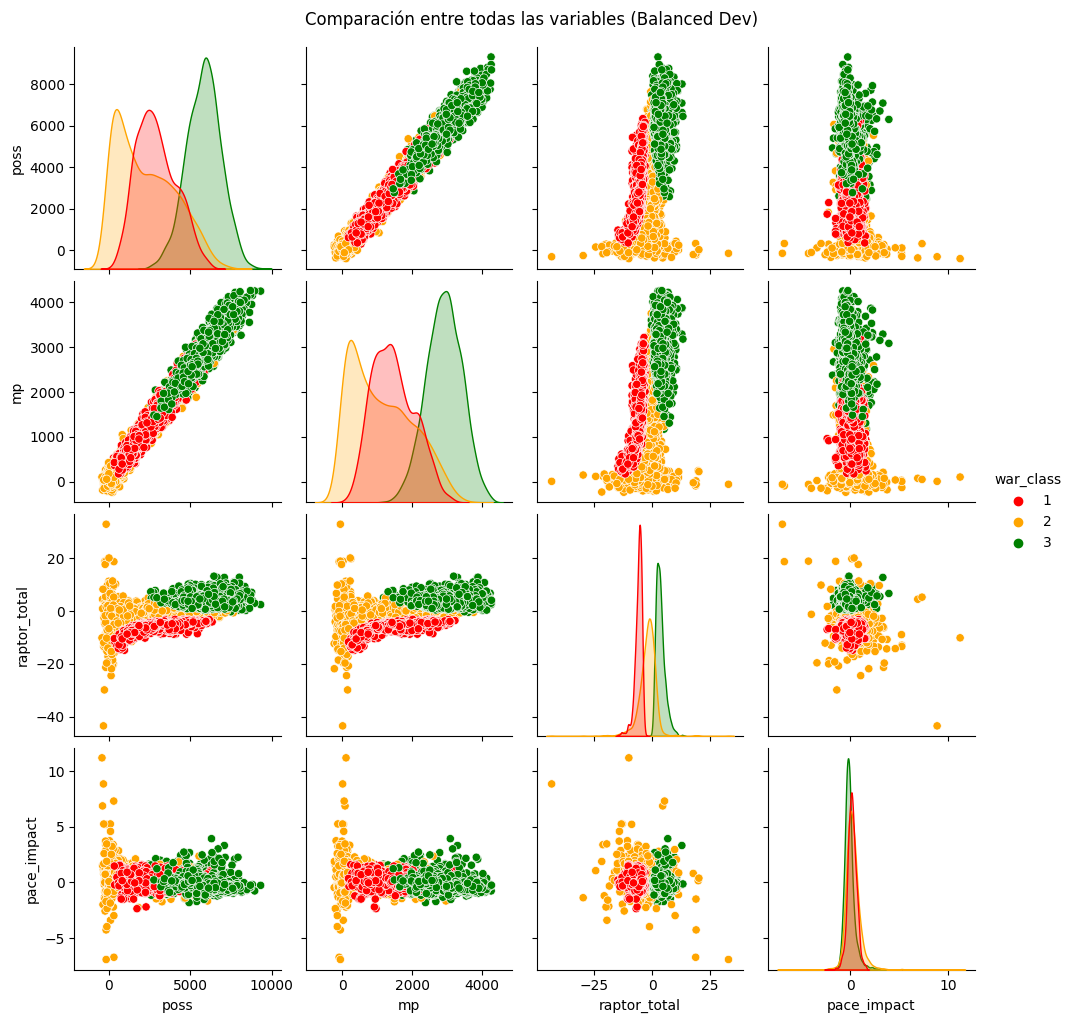

In [4]:
TARGET = "war_class"

# Hacer scatter plots de las columnas para comparar todas con todas, coloreando por Diagnosis
custom_palette = {1: "red", 2: "orange", 3: "green"}
sns.pairplot(dev_df, hue=TARGET, palette=custom_palette)
plt.suptitle('Comparación entre todas las variables (Balanced Dev)', y=1.02)
plt.show()

In [5]:
# Analizar la existencia de datos duplicados entre clases en dev_df

# Buscamos duplicados considerando solo las columnas de características (sin la clase)
feature_cols = [col for col in dev_df.columns if col != TARGET]

# Encontrar duplicados en las features
duplicates = dev_df.duplicated(subset=feature_cols, keep=False)

# Filas duplicadas
duplicated_rows = dev_df[duplicates]

# Verificamos si los duplicados pertenecen a diferentes clases
duplicated_diff_class = duplicated_rows.groupby(feature_cols)[TARGET].nunique()
duplicated_between_classes = duplicated_diff_class[duplicated_diff_class > 1]

print(f"Número de grupos de duplicados entre clases: {duplicated_between_classes.shape[0]}")
if not duplicated_between_classes.empty:
    print("Ejemplo(s) de duplicados entre clases:")
    display(
        dev_df.set_index(feature_cols)
        .loc[duplicated_between_classes.index]
        .reset_index()
        .sort_values(feature_cols)
    )
else:
    print("No se encontraron datos duplicados entre clases en dev_df.")

Número de grupos de duplicados entre clases: 0
No se encontraron datos duplicados entre clases en dev_df.


Distribución de clases en dev_df:
war_class
1    2029
2    2509
3    2244
Name: count, dtype: int64

Distribución de clases en test_df:
war_class
1    483
2    631
3    582
Name: count, dtype: int64


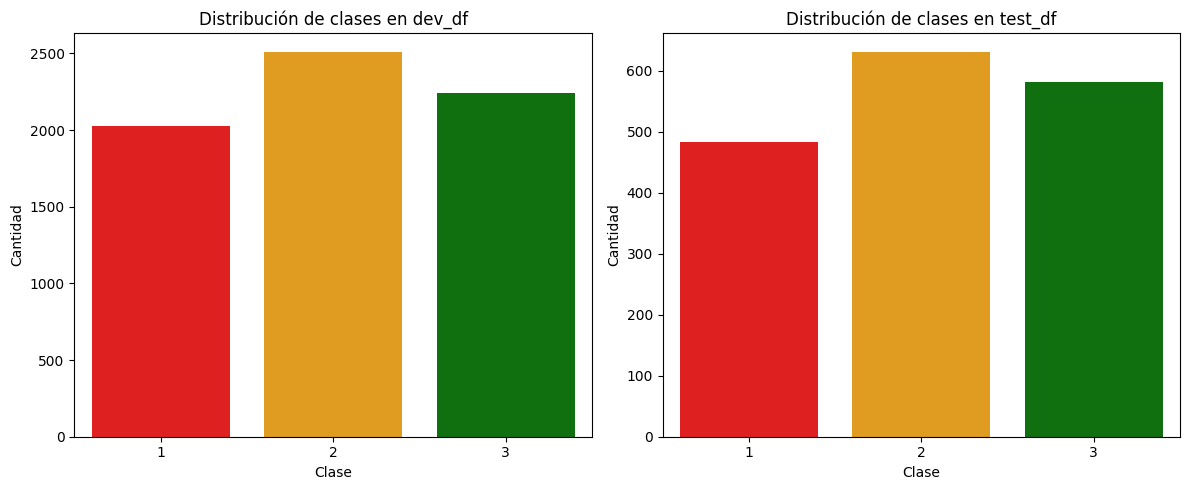

In [6]:
# Analizar si hay desbalanceo entre clases en dev_df y test_df

train_class_counts = dev_df[TARGET].value_counts().sort_index()
test_class_counts = test_df[TARGET].value_counts().sort_index()

print("Distribución de clases en dev_df:")
print(train_class_counts)
print("\nDistribución de clases en test_df:")
print(test_class_counts)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x=train_class_counts.index, y=train_class_counts.values, palette=custom_palette, ax=axes[0])
axes[0].set_title('Distribución de clases en dev_df')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Cantidad')

sns.barplot(x=test_class_counts.index, y=test_class_counts.values, palette=custom_palette, ax=axes[1])
axes[1].set_title('Distribución de clases en test_df')
axes[1].set_xlabel('Clase')
axes[1].set_ylabel('Cantidad')

plt.tight_layout()
plt.show()

Reporte de lo observado:

- Los datos no presentan Nans
- No hay datos faltantes ni columnas repetidas
- Las clases no estan desbalanceadas

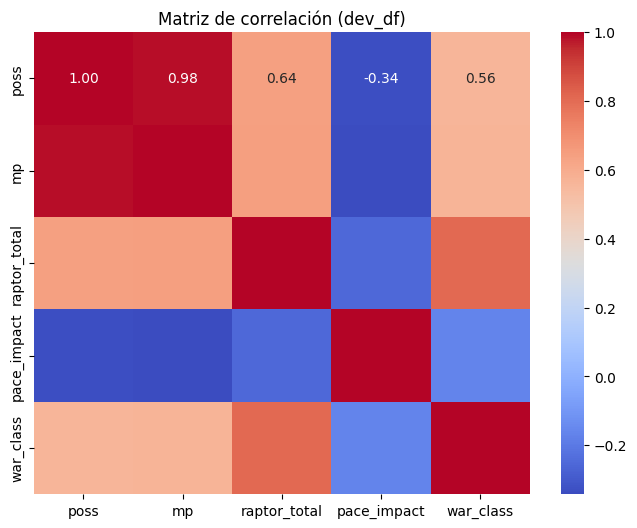

In [7]:
# Matriz de correlación para las variables numéricas en dev_df
corr_matrix = dev_df.corr()


plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación (dev_df)')
plt.show()

Poss y mp presentan una correlacion muy alta. Voy a probar eliminar una de las dos para evitar redundacia en el entrenamiento del modelo.

In [8]:
dev_df = dev_df.drop(columns=['poss'])
print(dev_df.head())

test_df = test_df.drop(columns=['poss'])
print(test_df.head())

            mp  raptor_total  pace_impact  war_class
0   826.890427     -3.369325     0.472195          2
1   567.265296     -5.389056     1.567405          2
2  2403.044668      7.084319    -0.534305          3
3  3709.114977      5.532538    -0.710111          3
4  3803.026613      5.089253    -0.699135          3
            mp  raptor_total  pace_impact  war_class
0  2120.470714      0.401757    -0.302839          2
1  2373.010068      1.902041     0.011706          3
2   -19.579157     -3.851309     0.530137          2
3   376.061499     -2.436397     0.617191          2
4  2499.540731      2.458754    -0.122485          3


ENTRENAMIENTO DE LOS MODELOS

In [9]:
# Separo en Train y Validation
train_df , val_df = pre.split_train_test(dev_df)

# Normalizacon (beneficia LDA y Logistic)
train_norm, val_norm, mu, sigma = pre.normalize(train_df, val_df, target_name=TARGET)

X_train = train_norm.drop(columns=[TARGET]).values
y_train = train_norm[TARGET].values
X_val   = val_norm.drop(columns=[TARGET]).values
y_val   = val_norm[TARGET].values

# 1) LDA    
lda = models.LDA()
lda.fit(X_train, y_train)
y_val_pred_lda = lda.predict(X_val)

# 2) Logistic Regression Multiclass

# Hago el barrido de lambdas para encontrar el mejor lambda
lambdas = np.logspace(-4, 2, 15)  # podés ajustar el rango/densidad
labels = np.unique(y_val)

hist = []  # guardo resultados por lambda
best = {"lambda": None, "f1_weighted": -1.0, "model": None}

for L2 in lambdas:
    clf = models.LogisticRegressionMulticlass(L2=L2, learning_rate=0.1, n_iter=1000)
    clf.fit(X_train, y_train)

    y_val_pred = clf.predict(X_val)

    # métricas
    f1_dict = metrics.f1_score(y_val, y_val_pred, labels)
    # weighted
    supports = np.array([(y_val == c).sum() for c in labels], dtype=float)
    f1_w = float(np.sum([f1_dict[c]*supports[i] for i, c in enumerate(labels)]) / supports.sum())
    # macro (por curiosidad)
    f1_m = float(np.mean([f1_dict[c] for c in labels]))
    acc   = float(metrics.accuracy(y_val, y_val_pred))

    hist.append({"lambda": L2, "f1_weighted": f1_w, "f1_macro": f1_m, "acc": acc})

    if f1_w > best["f1_weighted"]:
        best.update({"lambda": L2, "f1_weighted": f1_w, "model": clf})   

# Me guardo el mejor modelo y el mejor lambda
logreg = best["model"]
best_lambda = best["lambda"]

y_val_pred_log = logreg.predict(X_val)

# 3) Random Forest
rf = models.RandomForest(n_estimators=50, max_depth=5, max_features=None)
rf.fit(X_train, y_train)
y_val_pred_rf = rf.predict(X_val)

# Evaluacion rapida
labels = np.unique(y_val)
print("LDA Acc:", metrics.accuracy(y_val, y_val_pred_lda))
print("Logistic Acc:", metrics.accuracy(y_val, y_val_pred_log))
print("RF Acc:", metrics.accuracy(y_val, y_val_pred_rf))


c:\Users\Lucas\OneDrive\Escritorio\UdeSA\2025\Segundo Cuatrimestre\Aprendizaje Automatico y Profundo\Machine-Learning\Machine-Learning\TP2-Clasificacion-Multiclase\src\models.py:43: RuntimeWarning: overflow encountered in matmul
  z = X @ self.weights + self.bias
c:\Users\Lucas\OneDrive\Escritorio\UdeSA\2025\Segundo Cuatrimestre\Aprendizaje Automatico y Profundo\Machine-Learning\Machine-Learning\TP2-Clasificacion-Multiclase\src\models.py:54: RuntimeWarning: overflow encountered in multiply
  self.weights = (1.0 - lr * lam) * self.weights - lr * grad_w
c:\Users\Lucas\OneDrive\Escritorio\UdeSA\2025\Segundo Cuatrimestre\Aprendizaje Automatico y Profundo\Machine-Learning\Machine-Learning\TP2-Clasificacion-Multiclase\src\models.py:43: RuntimeWarning: invalid value encountered in matmul
  z = X @ self.weights + self.bias


LDA Acc: 0.9056742815033162
Logistic Acc: 0.9078850405305822
RF Acc: 0.9638909358879882


PRESENTACION DE LAS METRICAS GLOBALES DE CADA MODELO

In [10]:
modelos = {
    "LDA": lda,
    "LogReg Multiclass": logreg,
    "Random Forest": rf
}

labels = np.unique(y_val)

resultados = []
pr_curves = {m: {} for m in modelos}
roc_curves = {m: {} for m in modelos}

for nombre, modelo in modelos.items():
    # Predicciones
    y_pred = modelo.predict(X_val)
    y_proba = modelo.predict_proba(X_val)

    # ---- Métricas globales ----
    acc = metrics.accuracy(y_val, y_pred)
    prec = metrics.precision(y_val, y_pred, labels)
    rec = metrics.recall(y_val, y_pred, labels)
    f1 = metrics.f1_score(y_val, y_pred, labels)

    # ---- AUC y curvas OvA ----
    auc_roc_dict = {}
    auc_pr_dict = {}
    for i, c in enumerate(labels):
        y_true_bin = (y_val == c).astype(int)
        y_score = y_proba[:, i]

        # curvas
        P, R = metrics.pr_curve_ovr(y_true_bin, y_score)
        FPR, TPR = metrics.roc_curve_ovr(y_true_bin, y_score)
        pr_curves[nombre][c] = (R, P)
        roc_curves[nombre][c] = (FPR, TPR)

        # áreas
        auc_roc_dict[c] = round(metrics.auc_roc_ovr(y_true_bin, y_score), 4)
        auc_pr_dict[c] = round(metrics.auc_pr_ovr(y_true_bin, y_score), 4)

    resultados.append({
        "Modelo": nombre,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC-ROC": auc_roc_dict,
        "AUC-PR": auc_pr_dict
    })

# ---- Tabla compacta ----
tabla = pd.DataFrame([
    {
        "Modelo": r["Modelo"],
        "Accuracy": r["Accuracy"],
        "Precision": r["Precision"],
        "Recall": r["Recall"],
        "F1": r["F1"],
        "AUC-ROC (macro)": sum(r["AUC-ROC"].values())/len(r["AUC-ROC"]),
        "AUC-PR (macro)": sum(r["AUC-PR"].values())/len(r["AUC-PR"])
    }
    for r in resultados
]).set_index("Modelo")

import pandas as pd
import numpy as np

# labels ya definido arriba
classes = list(labels)

def _macro_avg(d, classes):
    # promedio simple sobre clases presentes en el dict
    vals = [d[c] for c in classes if c in d]
    return float(np.mean(vals)) if len(vals) > 0 else np.nan

# Construyo filas “planas” con columnas por clase
rows = []
for r in resultados:
    row = {
        "Modelo": r["Modelo"],
        "Accuracy": float(r["Accuracy"]),
        # promedios macro para resumen rápido
        "Precision (macro)": float(np.mean([r["Precision"][c] for c in classes])),
        "Recall (macro)":    float(np.mean([r["Recall"][c]    for c in classes])),
        "F1 (macro)":        float(np.mean([r["F1"][c]        for c in classes])),
        "AUC-ROC (macro)":   _macro_avg(r["AUC-ROC"], classes),
        "AUC-PR (macro)":    _macro_avg(r["AUC-PR"], classes),
    }

    # Métricas por clase (One-vs-All)
    for c in classes:
        row[f"Precision[{c}]"] = float(r["Precision"][c])
        row[f"Recall[{c}]"]    = float(r["Recall"][c])
        row[f"F1[{c}]"]        = float(r["F1"][c])
        row[f"AUC-ROC[{c}]"]   = float(r["AUC-ROC"][c])
        row[f"AUC-PR[{c}]"]    = float(r["AUC-PR"][c])

    rows.append(row)

tabla_completa = pd.DataFrame(rows).set_index("Modelo")

# Si no tenés Jinja2, evita .style; si lo tenés, queda más prolijo:
try:
    display(
        tabla_completa
        .sort_values("F1 (macro)", ascending=False)
        .style.format("{:.4f}")
        .set_caption("Métricas en Validación (OvA por clase y promedios macro)")
    )
except Exception:
    # fallback sin estilos
    print(tabla_completa.sort_values("F1 (macro)", ascending=False).round(4))


,Accuracy,Precision (macro),Recall (macro),F1 (macro),AUC-ROC (macro),AUC-PR (macro),Precision[1],Recall[1],F1[1],AUC-ROC[1],AUC-PR[1],Precision[2],Recall[2],F1[2],AUC-ROC[2],AUC-PR[2],Precision[3],Recall[3],F1[3],AUC-ROC[3],AUC-PR[3]
Modelo,,,,,,,,,,,,,,,,,,,,,
Random Forest,0.9639,0.9635,0.9654,0.9642,0.9905,0.9790,0.9444,0.9831,0.9634,0.9932,0.9818,0.9702,0.9287,0.9490,0.9831,0.9677,0.9758,0.9845,0.9801,0.9953,0.9876
LogReg Multiclass,0.9079,0.9095,0.9128,0.9074,0.9638,0.9461,0.8825,0.9590,0.9192,0.9856,0.9446,0.9485,0.7882,0.8610,0.9117,0.9081,0.8976,0.9911,0.9420,0.9942,0.9856
LDA,0.9057,0.9099,0.9117,0.9045,0.9698,0.9301,0.8651,0.9735,0.9161,0.9767,0.8701,0.9714,0.7617,0.8539,0.9356,0.9285,0.8931,1.0000,0.9435,0.9971,0.9918


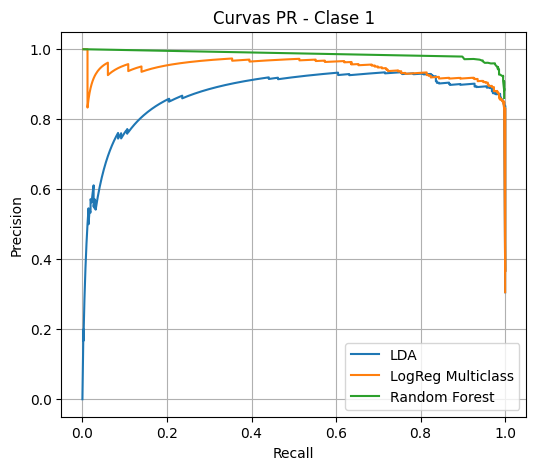

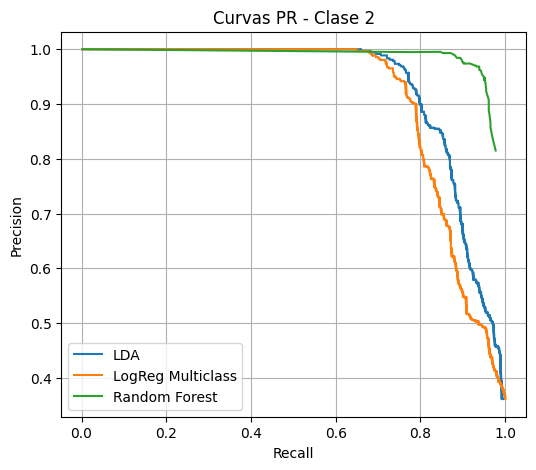

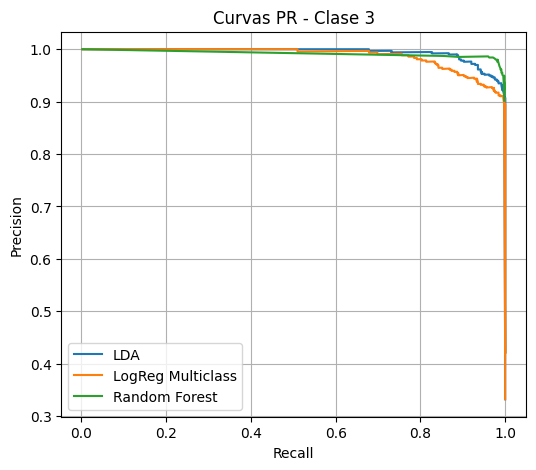

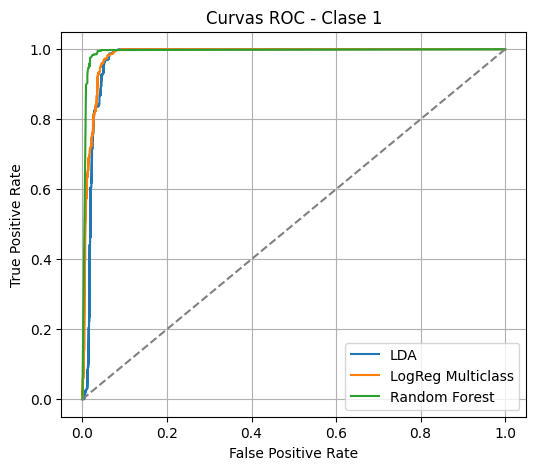

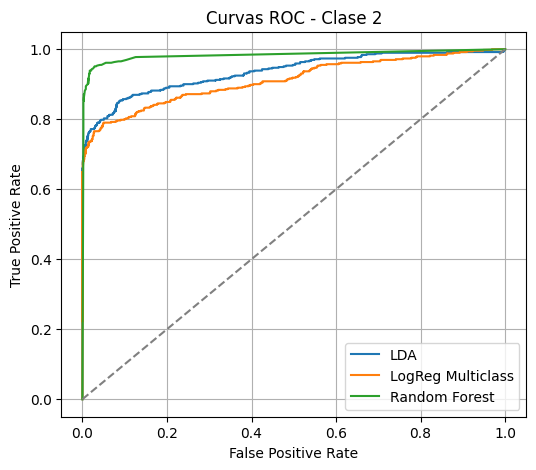

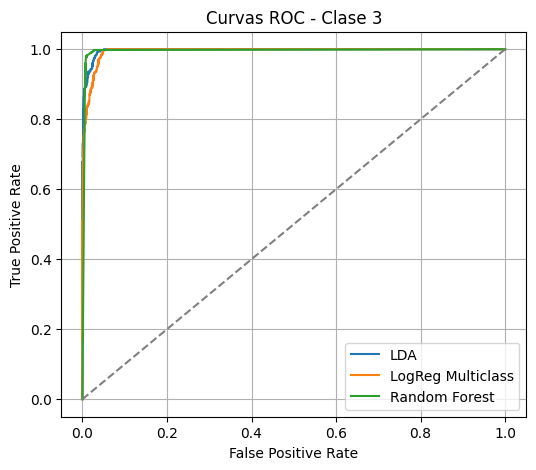

In [11]:
# PR Curves
for c in labels:
    plt.figure(figsize=(6,5))
    for nombre in modelos.keys():
        R, P = pr_curves[nombre][c]
        plt.plot(R, P, label=nombre)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Curvas PR - Clase {c}")
    plt.legend()
    plt.grid(True)
    plt.show()

# ROC Curves
for c in labels:
    plt.figure(figsize=(6,5))
    for nombre in modelos.keys():
        F, T = roc_curves[nombre][c]
        plt.plot(F, T, label=nombre)
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Curvas ROC - Clase {c}")
    plt.legend()
    plt.grid(True)
    plt.show()


REENTRENO LOS MODELOS USANDO EL SET DE DEV COMPLETO Y EVALUO EN TEST

In [12]:
# Uso el set de dev como train
train_df = dev_df

# Normalizacon (beneficia LDA y Logistic)
train_norm, test_df , mu, sigma = pre.normalize(train_df, test_df, target_name=TARGET)

X_train = train_norm.drop(columns=[TARGET]).values
y_train = train_norm[TARGET].values
X_test   = val_norm.drop(columns=[TARGET]).values
y_test   = val_norm[TARGET].values

# 1) LDA    
lda = models.LDA()
lda.fit(X_train, y_train)
y_test_pred_lda = lda.predict(X_test)

# 2) Logistic Regression Multiclass
logreg = models.LogisticRegressionMulticlass(L2=best_lambda, learning_rate=0.01, n_iter=1000)
logreg.fit(X_train, y_train)
y_test_pred_log = logreg.predict(X_test)

# 3) Random Forest
rf = models.RandomForest(n_estimators=50, max_depth=5, max_features=None)
rf.fit(X_train, y_train)
y_test_pred_rf = rf.predict(X_test)

# Evaluacion rapida
labels = np.unique(y_test)
print("LDA Acc:", metrics.accuracy(y_test, y_test_pred_lda))
print("Logistic Acc:", metrics.accuracy(y_test, y_test_pred_log))
print("RF Acc:", metrics.accuracy(y_test, y_test_pred_rf))

LDA Acc: 0.9093588798820929
Logistic Acc: 0.8798820928518791
RF Acc: 0.9668386145910096


PRESENTACION DE LAS METRICAS PARA LOS MODELOS ENTRENADOS CON TODO DEV

In [13]:
modelos = {
    "LDA": lda,
    "LogReg Multiclass": logreg,
    "Random Forest": rf
}

labels = np.unique(y_val)

resultados = []
pr_curves = {m: {} for m in modelos}
roc_curves = {m: {} for m in modelos}

for nombre, modelo in modelos.items():
    # Predicciones
    y_pred = modelo.predict(X_val)
    y_proba = modelo.predict_proba(X_val)

    # ---- Métricas globales ----
    acc = metrics.accuracy(y_val, y_pred)
    prec = metrics.precision(y_val, y_pred, labels)
    rec = metrics.recall(y_val, y_pred, labels)
    f1 = metrics.f1_score(y_val, y_pred, labels)

    # ---- AUC y curvas OvA ----
    auc_roc_dict = {}
    auc_pr_dict = {}
    for i, c in enumerate(labels):
        y_true_bin = (y_val == c).astype(int)
        y_score = y_proba[:, i]

        # curvas
        P, R = metrics.pr_curve_ovr(y_true_bin, y_score)
        FPR, TPR = metrics.roc_curve_ovr(y_true_bin, y_score)
        pr_curves[nombre][c] = (R, P)
        roc_curves[nombre][c] = (FPR, TPR)

        # áreas
        auc_roc_dict[c] = metrics.auc_roc_ovr(y_true_bin, y_score)
        auc_pr_dict[c] = metrics.auc_pr_ovr(y_true_bin, y_score)

    resultados.append({
        "Modelo": nombre,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC-ROC": auc_roc_dict,
        "AUC-PR": auc_pr_dict
    })

# ---- Tabla compacta ----
tabla = pd.DataFrame([
    {
        "Modelo": r["Modelo"],
        "Accuracy": r["Accuracy"],
        "AUC-ROC (macro)": sum(r["AUC-ROC"].values())/len(r["AUC-ROC"]),
        "AUC-PR (macro)": sum(r["AUC-PR"].values())/len(r["AUC-PR"])
    }
    for r in resultados
]).set_index("Modelo")

import pandas as pd
import numpy as np

# labels ya definido arriba
classes = list(labels)

def _macro_avg(d, classes):
    # promedio simple sobre clases presentes en el dict
    vals = [d[c] for c in classes if c in d]
    return float(np.mean(vals)) if len(vals) > 0 else np.nan

# Construyo filas “planas” con columnas por clase
rows = []
for r in resultados:
    row = {
        "Modelo": r["Modelo"],
        "Accuracy": float(r["Accuracy"]),
        # promedios macro para resumen rápido
        "Precision (macro)": float(np.mean([r["Precision"][c] for c in classes])),
        "Recall (macro)":    float(np.mean([r["Recall"][c]    for c in classes])),
        "F1 (macro)":        float(np.mean([r["F1"][c]        for c in classes])),
        "AUC-ROC (macro)":   _macro_avg(r["AUC-ROC"], classes),
        "AUC-PR (macro)":    _macro_avg(r["AUC-PR"], classes),
    }

    # Métricas por clase (One-vs-All)
    for c in classes:
        row[f"Precision[{c}]"] = float(r["Precision"][c])
        row[f"Recall[{c}]"]    = float(r["Recall"][c])
        row[f"F1[{c}]"]        = float(r["F1"][c])
        row[f"AUC-ROC[{c}]"]   = float(r["AUC-ROC"][c])
        row[f"AUC-PR[{c}]"]    = float(r["AUC-PR"][c])

    rows.append(row)

tabla_completa = pd.DataFrame(rows).set_index("Modelo")

try:
    display(
        tabla_completa
        .sort_values("F1 (macro)", ascending=False)
        .style.format("{:.4f}")
        .set_caption("Métricas en TEST (OvA por clase y promedios macro)")
    )
except Exception:
    print(tabla_completa.sort_values("F1 (macro)", ascending=False).round(4))


,Accuracy,Precision (macro),Recall (macro),F1 (macro),AUC-ROC (macro),AUC-PR (macro),Precision[1],Recall[1],F1[1],AUC-ROC[1],AUC-PR[1],Precision[2],Recall[2],F1[2],AUC-ROC[2],AUC-PR[2],Precision[3],Recall[3],F1[3],AUC-ROC[3],AUC-PR[3]
Modelo,,,,,,,,,,,,,,,,,,,,,
Random Forest,0.9668,0.9664,0.9686,0.9671,0.9929,0.9839,0.9427,0.9904,0.9659,0.9961,0.9880,0.9785,0.9287,0.9530,0.9866,0.9741,0.9780,0.9867,0.9823,0.9961,0.9895
LDA,0.9094,0.9146,0.9158,0.9082,0.9707,0.9323,0.8665,0.9855,0.9222,0.9782,0.8747,0.9842,0.7617,0.8588,0.9367,0.9303,0.8931,1.0000,0.9435,0.9971,0.9917
LogReg Multiclass,0.8799,0.8890,0.8874,0.8782,0.9465,0.9113,0.8830,0.9639,0.9217,0.9782,0.8979,0.9582,0.7006,0.8094,0.8658,0.8476,0.8257,0.9978,0.9036,0.9955,0.9884


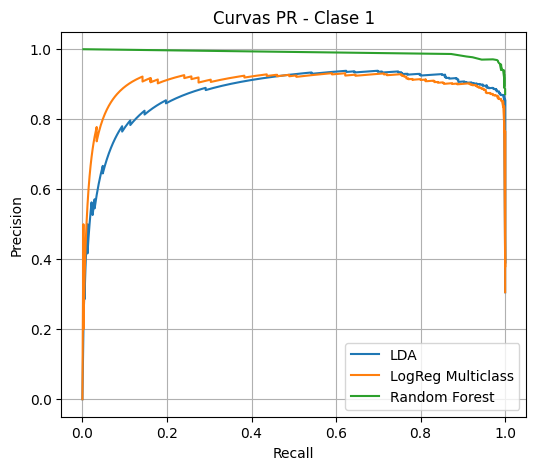

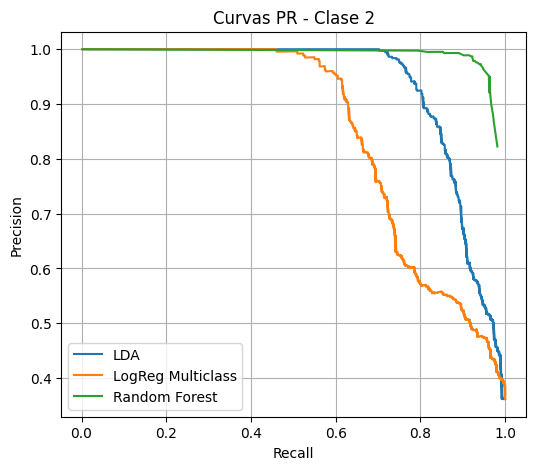

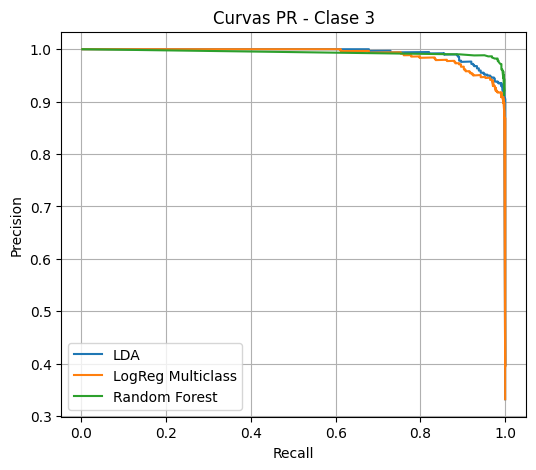

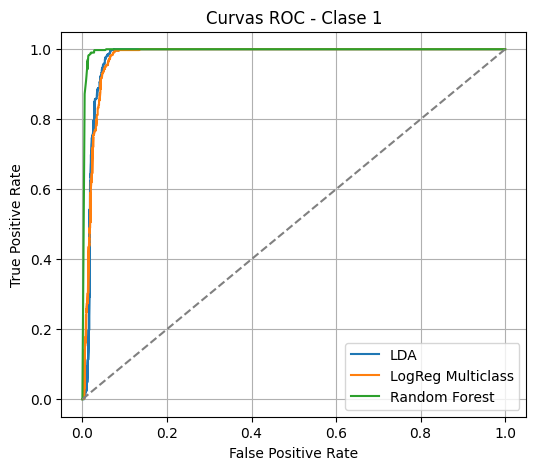

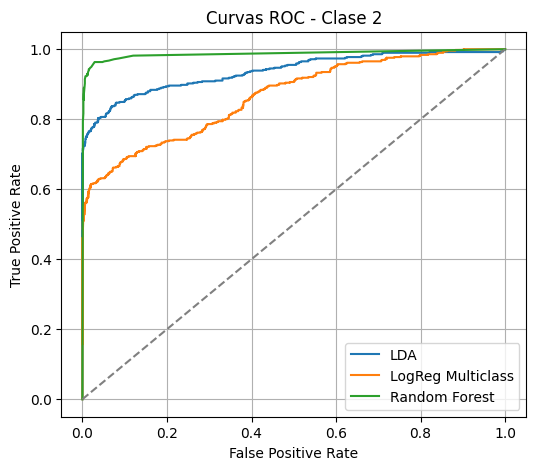

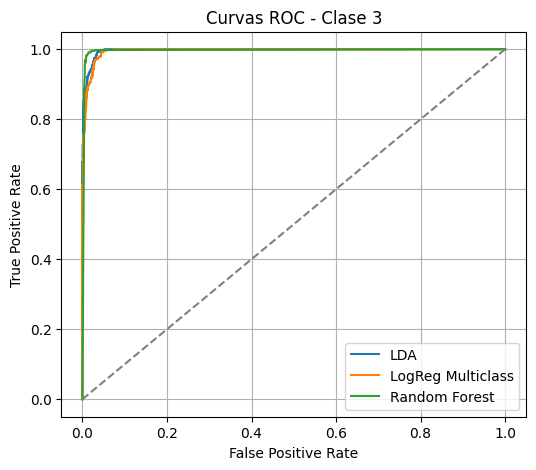

In [14]:
# PR Curves
for c in labels:
    plt.figure(figsize=(6,5))
    for nombre in modelos.keys():
        R, P = pr_curves[nombre][c]
        plt.plot(R, P, label=nombre)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Curvas PR - Clase {c}")
    plt.legend()
    plt.grid(True)
    plt.show()

# ROC Curves
for c in labels:
    plt.figure(figsize=(6,5))
    for nombre in modelos.keys():
        F, T = roc_curves[nombre][c]
        plt.plot(F, T, label=nombre)
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Curvas ROC - Clase {c}")
    plt.legend()
    plt.grid(True)
    plt.show()

ANALISIS FINAL DE LOS MODELOS Y SELECCION PARA UN ENTORNO DE PRODUCCION

Si vemos los datos de las metricas Random Foreste es ampliamente superior.

Tiene el mejor desempeño en Accuracy, Precision, Recall, F1 y sobre todo en AUC-ROC (0.993) y AUC-PR (0.984). Osea que no solo clasifica correctamente la mayoria de los casos, sino que tambien mantiene una excelente discriminacion entre clases en todos los umbrales. 

El unico riesgo que le veo es que es menos interpretable y más costoso en computo que LDA o LogReg, aunque hoy en produccion esto rara vez es un problema serio.

Solo consideraría LDA en un contexto donde la interpretabilidad sea absolutamente prioritaria, o donde el costo de cómputo sea una restricción crítica.